<a href="https://colab.research.google.com/github/shamalle/emotion_recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion recognition with neural network

## Data set used: Fer2013

* approx. 30'000 facial RGB images 
* 48x48 pixels
* 7 classes: angry (0), disgust (1), fear (2), happy (3), sad (4), suprise (5), neutral (6)
* ~ 5'000 samples/class with exception of disgust (1): 600 samples

In [89]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomRotation, Grayscale
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import random
import cv2 # pip install opencv-python
import pandas as pd
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/data_directory.zip" /content/data.zip
!unzip /content/data.zip -d /content/data/

# Data analysis: Distribution of classes and visualisation of samples

First, helper functions are defined

In [ ]:
def count_samples(path, set_):
  ''' Counts amount of samples of each class in train set and in test set'''
  expr_amount_dict = {}
  # go through each expression
  for expr in os.listdir(path):
    dir_ = path + '/' + expr
    # save amount of samples to each expression
    expr_amount_dict[expr] = len(os.listdir(dir_))
  
  # nice visualisation with pd
  df = pd.DataFrame(expr_amount_dict, index=[set_])
  return df


def plot_images(img_dir, title):
  '''Plots 5 random images from given directory'''
  all_imgs = os.listdir(img_dir)
  rndm_samples = random.sample(range(0, len(all_imgs)), 5)
  img_files = [os.path.join(img_dir, file) for file in all_imgs]
  rndm_imgs = itemgetter(*rndm_samples)(img_files)
  
  plt.figure(figsize=(12, 12))
  for idx, img_path in enumerate(rndm_imgs):
    plt.subplot(5, 5, idx+1)
    img = plt.imread(img_path)
    plt.title(title)
    plt.axis('off')         
    plt.imshow(img, cmap='Greys_r') 

In [60]:
# Google colab directories:
train_dir = '/content/data/data_directory/train'
test_dir = '/content/data/data_directory/test'

In [62]:
train_count = count_samples(train_dir, 'train')
test_count = count_samples(test_dir, 'test')
print(train_count)
print(test_count)

       disgust   sad  fear  happy  surprise  neutral  angry
train      436  4830  4097   7215      3171     4965   3995
      disgust   sad  fear  happy  surprise  neutral  angry
test      111  1247  1024   1774       831     1233    958


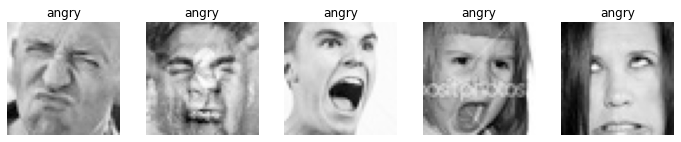

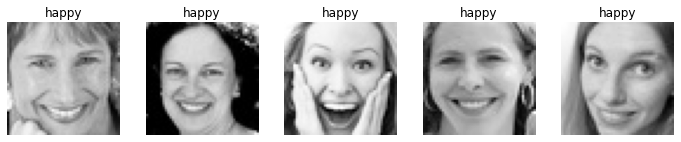

In [96]:
emotion = 'angry'
emotion_2 = 'happy'

plot_images(train_dir+'/'+emotion, emotion)
plot_images(train_dir+'/'+emotion_2, emotion_2)

# Data preparation

Helper functions to load/split data.

Transformations used: Grayscale, random rotation and random horizontal flip. This helps to not have a fixating model on unnecessary stuff

**Important**: The test set is splitted randomly in a test and validation part. Of course, such random splitting doesn't ensure same distribution of occurrences of each class. One can ensure that with the principle of _stratified_ _sampling_. This had not been done in this project. One could do that with:

* the sampler interface in Pytorch
* iterate through a random permutation of samples and evenly distribute them manually to the sets

In [57]:
def split_data(dataset, split_ratio):
  '''Splits the given data set into two subsets with given split ratio.
  First value in list corresponds to split_ratio * dataset'''
  splitted_sets = []

  dataset_size = len(dataset)
  splitted_size = int(split_ratio * dataset_size)
  rest_size = dataset_size - splitted_size

  splitted_sets.append(splitted_size)
  splitted_sets.append(rest_size)

  return splitted_sets


def load_data(train_dir, test_dir, split_ratio, batch_size):
  '''Loads datasets for training (which is splitted into a validation part) and for testing.
  Split ratio defines how much of the train set stays for training, the rest goes to validation'''

  # define transformations for training samples: composition of different manipulations (see them above)
  transforms_train = Compose([Grayscale(),
                              RandomRotation(40),
                              RandomHorizontalFlip(),
                              ToTensor()])
  # do the same for test samples (rotations, flips are not needed since model doesnt train with these) 
  transforms_test = Compose([Grayscale(),
                             ToTensor()])
  
  # Create dataset objects and split train -> train + validation
  train_dataset = ImageFolder(train_dir, loader=Image.open, transform=transforms_train)
  test_ds = ImageFolder(test_dir, loader=Image.open, transform=transforms_test)

  sizes_train_val = split_data(train_dataset, split_ratio)
  train_ds, val_ds = torch.utils.data.random_split(train_dataset, sizes_train_val)

  # Create dataloader object
  train_dl= DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

  return train_dl, val_dl, test_dl


def visualize_dataloader(dataloader):
  '''Visualize some of the now transformed images'''
  for imgs, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis('off') 
    print(imgs[0].shape)
    ax.imshow(make_grid(imgs[:40], nrow=8).permute(1, 2, 0))
    break

In [58]:
# load datasets with above defined function (90 percent of training is cut for validation) into data loaders
train_dl, val_dl, test_dl = load_data(train_dir, test_dir, 0.9, 64)

print('Training set size: ' + str(len(train_dl.dataset)) + ', Validation set size: ' + str(len(val_dl.dataset)) + ', Test set size: ' + str(len(test_dl.dataset)))

Training set size: 25838, Validation set size: 2871, Test set size: 7178


torch.Size([1, 48, 48])


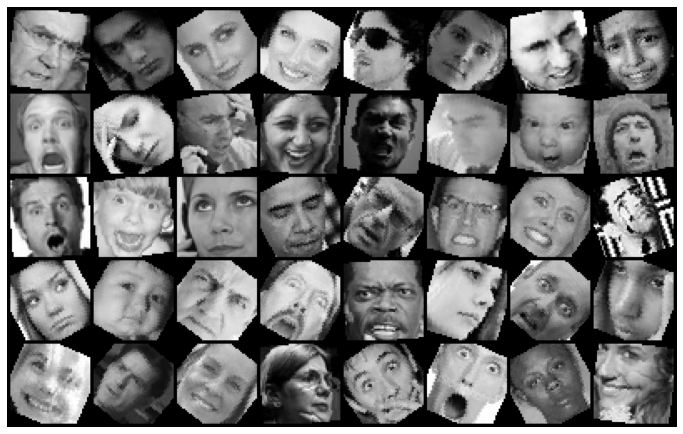

In [111]:
visualize_dataloader(train_dl)

## Defining model

## Training, evaluation and testing

## Conclusion